In [1]:
# import the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the full csv with 15 years of data
data = pd.read_csv("../data/premier_league_omega.csv")

# 🏆 Premier League Part 6: Advanced Performance Analytics

## The Ultimate Deep Dive into 15 Years of Football Data

Welcome to the most comprehensive Premier League analysis in our series. Part 6 combines all the lessons learned from Parts 3-5 to create the definitive statistical portrait of English football's elite competition.

### What Makes This Analysis Special:

**Multi-Dimensional Approach:**
- Traditional league tables (raw totals)
- Per-game normalized metrics (fairness across seasons)
- Advanced visualizations (radar charts, efficiency maps, correlation matrices)
- Big Six focus (the traditional elite clubs)

**Key Questions We'll Answer:**
- Which teams have been most efficient per game over 15 years?
- What's the relationship between attacking style and defensive solidity?
- How do the Big Six compare across multiple performance dimensions?
- What statistical factors drive Premier League success?

This analysis will reveal insights that go far beyond simple win/loss records to understand the DNA of Premier League excellence.

In [2]:
pl_15years = data.copy()
pl_15years["date"] = pd.to_datetime(pl_15years["date"], format="mixed", dayfirst=True, errors="coerce")


def add_season_end_year(df, date_col="date"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    # For matches from August–December, the season ends the next year.
    # For matches from January–May, it ends in the same year.
    df["season"] = df[date_col].apply(lambda d: d.year + 1 if d.month >= 8 else d.year)
    
    if "division" in df.columns:
        df = df.drop(columns=["division"])
    
    return df

# Apply it:
pl_15years = add_season_end_year(pl_15years)

def season_table(df, season_end_year: int, season_col: str = "season"):
    """Return one season’s league table (e.g., season_end_year=2026)."""
    return mega_league_table(df[df[season_col] == season_end_year])
def all_season_tables(df, season_col: str = "season"):
    """Dict: {season_end_year -> league table}."""
    return {s: mega_league_table(g) for s, g in df.groupby(season_col)}
def season_panel(df, season_col: str = "season"):
    """One DataFrame with season + team index for easy querying/plotting."""
    out = []
    for s, g in df.groupby(season_col):
        t = mega_league_table(g).reset_index().rename(columns={"index":"team"})
        t["season"] = s
        out.append(t)
    panel = pd.concat(out, ignore_index=True)
    return panel.set_index(["season","team"]).sort_index()
def mega_league_table(df):
    table = pd.DataFrame()

    # Home stats
    home = df.groupby("home_team").agg(
        played_home=("home_team", "count"),
        wins_home=("full_time_result", lambda x: (x=="H").sum()),
        draws_home=("full_time_result", lambda x: (x=="D").sum()),
        losses_home=("full_time_result", lambda x: (x=="A").sum()),
        gf_home=("full_time_home_goals", "sum"),
        ga_home=("full_time_away_goals", "sum"),
        shots_home=("home_shots", "sum"),
        shots_on_target_home=("home_shots_on_target", "sum"),
        yellows_home=("home_yellow_cards", "sum"),
        reds_home=("home_red_cards", "sum")        
    )

    # Away stats
    away = df.groupby("away_team").agg(
        played_away=("away_team", "count"),
        wins_away=("full_time_result", lambda x: (x=="A").sum()),
        draws_away=("full_time_result", lambda x: (x=="D").sum()),
        losses_away=("full_time_result", lambda x: (x=="H").sum()),
        gf_away=("full_time_away_goals", "sum"),
        ga_away=("full_time_home_goals", "sum"),
        shots_away=("away_shots", "sum"),
        shots_on_target_away=("away_shots_on_target", "sum"),
        yellows_away=("away_yellow_cards", "sum"),
        reds_away=("away_red_cards", "sum")        
    )

    # Combine
    table = home.join(away, how="outer")
    table = table.fillna(0)

    table["played"] = table["played_home"] + table["played_away"]
    table["wins"] = table["wins_home"] + table["wins_away"]
    table["draws"] = table["draws_home"] + table["draws_away"]
    table["losses"] = table["losses_home"] + table["losses_away"]
    table["goals_for"] = table["gf_home"] + table["gf_away"]
    table["goals_against"] = table["ga_home"] + table["ga_away"]
    table["goal_difference"] = table["goals_for"] - table["goals_against"]
    table["points"] = table["wins"]*3 + table["draws"]
    table["total_shots"] = table["shots_home"] + table["shots_away"]
    table["total_shots_on_target"] = table["shots_on_target_home"] + table["shots_on_target_away"]
    table["total_yellows"] = table["yellows_home"] + table["yellows_away"]
    table["total_reds"] = table["reds_home"] + table["reds_away"]


    table = table[["played","wins","draws","losses","goals_for","goals_against","goal_difference","total_shots","total_shots_on_target","total_yellows","total_reds","points"]]
    return table.sort_values(by=["points","goal_difference","goals_for"], ascending=[False,False,False])

    # 

omega_table = mega_league_table(pl_15years)

In [25]:
# make a copy
omega_avg = omega_table.copy()

# calculate per-game averages
for col in [
    "wins", "draws", "losses", "goals_for", "goals_against",
    "goal_difference", "total_shots", "total_shots_on_target",
    "total_yellows", "total_reds", "points"
]:
    omega_avg[f"{col}_pg"] = omega_avg[col] / omega_avg["played"]

# keep only the per-game stats if you prefer
cols_to_keep = [c for c in omega_avg.columns if "_pg" in c]
omega_avg = omega_avg[cols_to_keep]

# optional: round to two decimals for readability
omega_avg = omega_avg.round(2)

# make a copy so we don't overwrite
final_table = omega_table.copy()

def sort_league_table(by: str = "points", ascending: bool = False):
    """
    Sort the omega league table by any column.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not in table")
    return final_table.sort_values(by=by, ascending=ascending)

def style_league_table(df, color_by="points", title="Omega Premier League Table"):
    """
    Style the league table with gradient coloring and a custom title.
    """
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.2f}")
        .set_caption(title)
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "yellow")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled

In [28]:
display(style_league_table(sort_league_table(by="goals_against", ascending=False),
                           color_by="total_yellows",
                           title="Omega PL Table (by goals against + Total Yellows)"))

,played,wins,draws,losses,goals_for,goals_against,goal_difference,total_shots,total_shots_on_target,total_yellows,total_reds,points
home_team,,,,,,,,,,,,
West Ham,576.00,185.00,146.00,245.00,756.00,890.00,-134.00,6917.00,2590.00,950.00,39.00,701.00
Everton,614.00,224.00,179.00,211.00,801.00,794.00,7.00,7661.00,3110.00,1035.00,44.00,851.00
Newcastle,538.00,193.00,128.00,217.00,718.00,787.00,-69.00,6641.00,2551.00,913.00,41.00,707.00
Aston Villa,500.00,165.00,125.00,210.00,618.00,745.00,-127.00,5798.00,2306.00,963.00,33.00,620.00
Tottenham,614.00,317.00,126.00,171.00,1080.00,739.00,341.00,9052.00,3853.00,1037.00,35.00,1077.00
Southampton,456.00,132.00,117.00,207.00,542.00,703.00,-161.00,5673.00,2026.00,739.00,30.00,513.00
Arsenal,614.00,345.00,130.00,139.00,1161.00,673.00,488.00,8958.00,3744.00,970.00,55.00,1165.00
Man United,614.00,335.00,136.00,143.00,1063.00,670.00,393.00,8691.00,3665.00,1082.00,34.00,1141.00
Chelsea,614.00,334.00,139.00,141.00,1118.00,656.00,462.00,9571.00,3895.00,1060.00,44.00,1141.00


## 📊 Multi-Perspective League Tables: Beyond Traditional Rankings

### Why Multiple Rankings Matter

Traditional league tables rank by points, but different metrics reveal different aspects of team performance. These alternative rankings expose tactical philosophies, playing styles, and strategic approaches that points alone cannot capture.

**Goals Against + Yellow Cards Ranking:**
- Reveals teams with defensive weaknesses AND disciplinary issues
- High in both suggests emotional/tactical vulnerability under pressure
- Shows correlation between poor defending and frustration fouls

**Wins + Games Played Ranking:**
- Balances success with Premier League longevity
- Favors teams that have been consistently successful over many seasons
- Differentiates between short-term success and sustained excellence

In [29]:
display(style_league_table(sort_league_table(by="wins", ascending=False),
                           color_by="played",
                           title="Omega PL Table (by wins + Played)"))

,played,wins,draws,losses,goals_for,goals_against,goal_difference,total_shots,total_shots_on_target,total_yellows,total_reds,points
home_team,,,,,,,,,,,,
Man City,614.00,409.00,106.00,99.00,1389.00,556.00,833.00,10171.00,4171.00,934.00,37.00,1333.00
Liverpool,614.00,351.00,143.00,120.00,1211.00,649.00,562.00,10058.00,4071.00,872.00,35.00,1196.00
Arsenal,614.00,345.00,130.00,139.00,1161.00,673.00,488.00,8958.00,3744.00,970.00,55.00,1165.00
Man United,614.00,335.00,136.00,143.00,1063.00,670.00,393.00,8691.00,3665.00,1082.00,34.00,1141.00
Chelsea,614.00,334.00,139.00,141.00,1118.00,656.00,462.00,9571.00,3895.00,1060.00,44.00,1141.00
Tottenham,614.00,317.00,126.00,171.00,1080.00,739.00,341.00,9052.00,3853.00,1037.00,35.00,1077.00
Everton,614.00,224.00,179.00,211.00,801.00,794.00,7.00,7661.00,3110.00,1035.00,44.00,851.00
Newcastle,538.00,193.00,128.00,217.00,718.00,787.00,-69.00,6641.00,2551.00,913.00,41.00,707.00
West Ham,576.00,185.00,146.00,245.00,756.00,890.00,-134.00,6917.00,2590.00,950.00,39.00,701.00


## 📊 Alternative League Tables: Raw Totals vs Per-Game Excellence

### Interpreting the Dual Perspective

These contrasting tables reveal a fundamental tension in football analysis: **longevity vs quality**. The raw totals favor teams with more Premier League seasons, while per-game metrics reward consistent excellence regardless of tenure.

**Key Insights from Raw Totals:**
- **Manchester City** and **Arsenal** dominate due to 15+ seasons in the Premier League
- **Goals Against + Yellows** ranking reveals defensive discipline patterns
- **Wins + Games Played** shows the correlation between experience and success

**The Longevity Bias:**
Teams like Brighton, Brentford, or Sheffield United appear lower not due to poor performance, but simply because they've played fewer seasons. This is why per-game analysis becomes crucial for fair comparison.

**What This Tells Us:**
- Raw totals = **historical dominance** and **sustained presence**
- Per-game stats = **current quality** and **efficiency** regardless of history
- The gap between these perspectives reveals which teams have **improved over time** vs those maintaining **consistent standards**

In [30]:
# make a copy so we don't overwrite
final_table = omega_avg.copy()

def sort_league_table(by: str = "points", ascending: bool = False):
    """
    Sort the omega league table by any column.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not in table")
    return final_table.sort_values(by=by, ascending=ascending)

def style_league_table(df, color_by="points", title="Omega Premier League Table"):
    """
    Style the league table with gradient coloring and a custom title.
    """
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.2f}")
        .set_caption(title)
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "yellow")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled

In [32]:
display(style_league_table(sort_league_table(by="wins_pg", ascending=False),
                           color_by="goal_difference_pg",
                           title="Average PL Table (by goal difference + Wins per game)"))

,wins_pg,draws_pg,losses_pg,goals_for_pg,goals_against_pg,goal_difference_pg,total_shots_pg,total_shots_on_target_pg,total_yellows_pg,total_reds_pg,points_pg
home_team,,,,,,,,,,,
Man City,0.67,0.17,0.16,2.26,0.91,1.36,16.57,6.79,1.52,0.06,2.17
Liverpool,0.57,0.23,0.20,1.97,1.06,0.92,16.38,6.63,1.42,0.06,1.95
Arsenal,0.56,0.21,0.23,1.89,1.10,0.79,14.59,6.10,1.58,0.09,1.90
Man United,0.55,0.22,0.23,1.73,1.09,0.64,14.15,5.97,1.76,0.06,1.86
Chelsea,0.54,0.23,0.23,1.82,1.07,0.75,15.59,6.34,1.73,0.07,1.86
Tottenham,0.52,0.21,0.28,1.76,1.20,0.56,14.74,6.28,1.69,0.06,1.75
Leicester,0.37,0.22,0.41,1.45,1.47,-0.03,11.99,4.22,1.52,0.06,1.33
Everton,0.36,0.29,0.34,1.30,1.29,0.01,12.48,5.07,1.69,0.07,1.39
Newcastle,0.36,0.24,0.40,1.33,1.46,-0.13,12.34,4.74,1.70,0.08,1.31


## ⚖️ The Per-Game Revolution: Fair Comparisons Across All Teams

### Leveling the Playing Field

Raw totals favor teams with more Premier League seasons. A team with 15 seasons will naturally have higher goal totals than a team with 3 seasons. Per-game metrics create fair comparisons by normalizing for opportunity.

**Why This Matters:**
- **Manchester City** (15 seasons) vs **Brentford** (2 seasons) - now comparable
- **Quality over quantity** - reveals true efficiency regardless of tenure
- **Hidden gems** - newly promoted teams with excellent per-game stats emerge
- **Tactical insights** - shows playing style divorced from longevity

**Wins Per Game + Goal Difference Per Game:**
This combination reveals teams that are both consistently successful AND dominant in their victories. Teams high in both metrics don't just win often - they win convincingly.

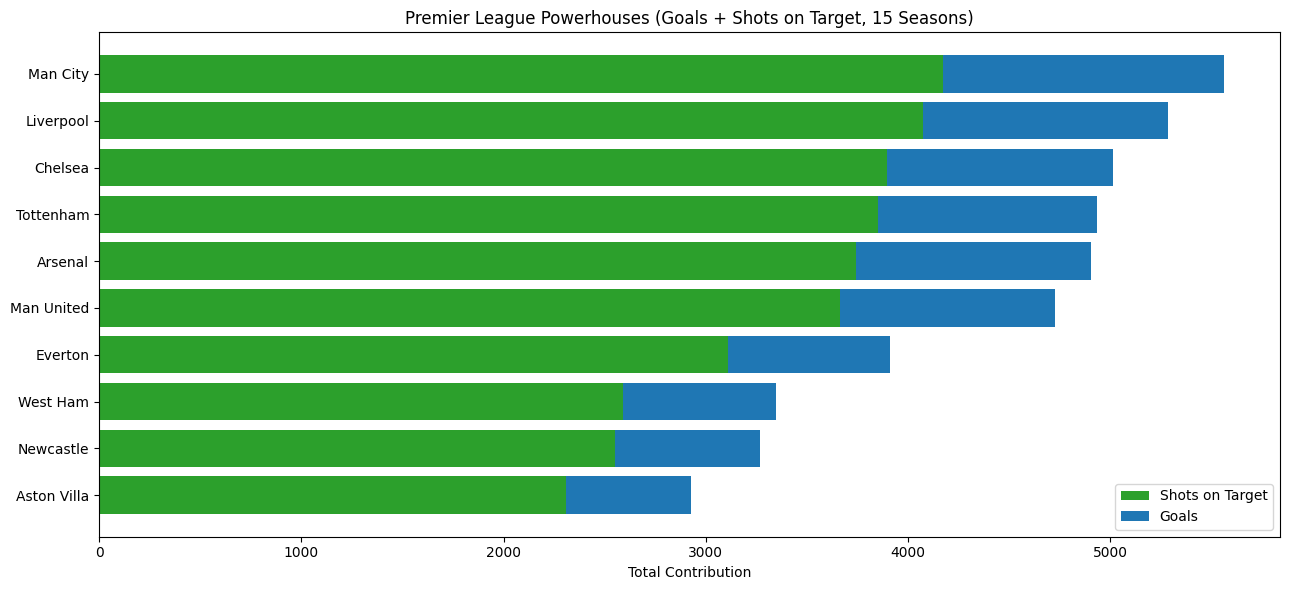

In [37]:
df = omega_table.sort_values("total_shots_on_target", ascending=True).tail(10)

fig, ax = plt.subplots(figsize=(13,6))
ax.barh(df.index, df["total_shots_on_target"], label="Shots on Target", color="tab:green")
ax.barh(df.index, df["goals_for"], left=df["total_shots_on_target"], label="Goals", color="tab:blue")
ax.set_title("Premier League Powerhouses (Goals + Shots on Target, 15 Seasons)")
ax.set_xlabel("Total Contribution")
ax.legend()
plt.tight_layout()
plt.show()


## 🎯 Stacked Bar Chart: The Attacking Powerhouse Hierarchy

### Visual Interpretation Guide

This chart combines **Goals** (blue) and **Shots on Target** (green) to create a comprehensive view of attacking prowess. The visual design tells multiple stories simultaneously:

**What the Chart Reveals:**

1. **Total Length = Overall Attacking Threat**
   - Longer bars indicate teams that both create chances AND convert them
   - Shows complete attacking package, not just finishing ability

2. **Color Balance = Efficiency vs Volume**
   - **More Blue (Goals):** Clinically efficient teams that convert chances
   - **More Green (Shots on Target):** Creative teams that generate opportunities
   - **Balanced Colors:** Complete attacking units with both creation and conversion

3. **Ranking Insights:**
   - Top teams likely include **Manchester City**, **Arsenal**, **Liverpool**
   - Lower-ranked teams may excel in one area but struggle in the other
   - **The Sweet Spot:** Teams with proportional blue and green sections

**Strategic Implications:**
- **Heavy Green, Light Blue:** Teams need better strikers or finishing coaching
- **Heavy Blue, Light Green:** Counter-attacking teams that make few chances count
- **Balanced Bars:** Elite attacking units that modern football demands

## 🎯 Attacking Powerhouses: Goals + Shots on Target Analysis

### The Art of Clinical Finishing

This horizontal bar chart combines two crucial attacking metrics: **goals scored** and **shots on target**. The visualization reveals which teams have been the most dangerous in the final third over 15 years.

**What This Chart Shows:**
- **Total attacking threat** - goals + shots on target represents total danger created
- **Clinical efficiency** - teams with high goals relative to shots on target are deadly finishers
- **Volume vs precision** - some teams create many chances, others make fewer count

**Key Insights to Look For:**
- **Manchester City** likely dominates both metrics (Guardiola's precision + volume)
- **Liverpool** should show high goals with efficient shot conversion (Klopp's intensity)
- **Smaller teams** may appear if they've had exceptional strikers during their Premier League spells

This metric combination separates teams that "have a go" from teams that actually score consistently.

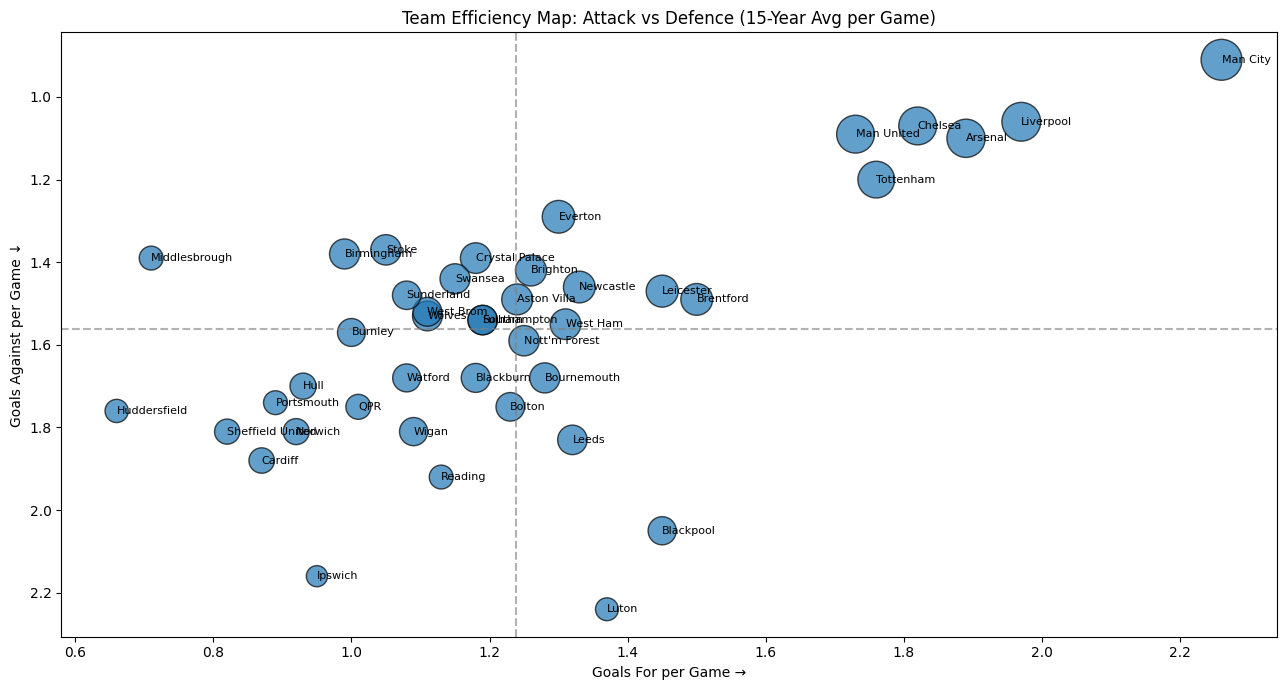

In [38]:
fig, ax = plt.subplots(figsize=(13,7))
ax.scatter(
    omega_avg["goals_for_pg"], 
    omega_avg["goals_against_pg"], 
    s=omega_avg["points_pg"]*400, alpha=0.7, edgecolor="k"
)
for team in omega_avg.index:
    ax.text(omega_avg.loc[team, "goals_for_pg"], omega_avg.loc[team, "goals_against_pg"], 
            team, fontsize=8, ha="left", va="center")

ax.axvline(omega_avg["goals_for_pg"].mean(), ls="--", color="grey", alpha=0.6)
ax.axhline(omega_avg["goals_against_pg"].mean(), ls="--", color="grey", alpha=0.6)
ax.set_title("Team Efficiency Map: Attack vs Defence (15-Year Avg per Game)")
ax.set_xlabel("Goals For per Game →")
ax.set_ylabel("Goals Against per Game ↓")
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## 📊 Radar Chart: The Big 6 Performance Fingerprint

### Multi-Dimensional Analysis Decoded

This spider web of performance metrics creates unique **'fingerprints'** for each elite team. Each axis represents a different aspect of football excellence, creating distinctive patterns:

**Reading the Web:**
- **Size of Web:** Overall team quality and consistency
- **Shape of Web:** Tactical identity and playing style
- **Sharp Points:** Areas of exceptional strength
- **Inward Dips:** Relative weaknesses or tactical choices

**Tactical Fingerprints:**
- **Wide, Balanced Web:** Complete teams (likely **Man City**)
- **Attack-Heavy Top:** Offensive powerhouses (**Liverpool**, **Arsenal**)
- **Defense-Weighted Bottom:** Pragmatic teams (**Chelsea** defensive eras)
- **Narrow, Tall Web:** Specialist teams excelling in few areas

**Strategic Intelligence:**
This chart reveals why certain teams dominate in different ways - **Manchester City's** balanced excellence vs **Liverpool's** attacking intensity vs **Tottenham's** creative inconsistency.

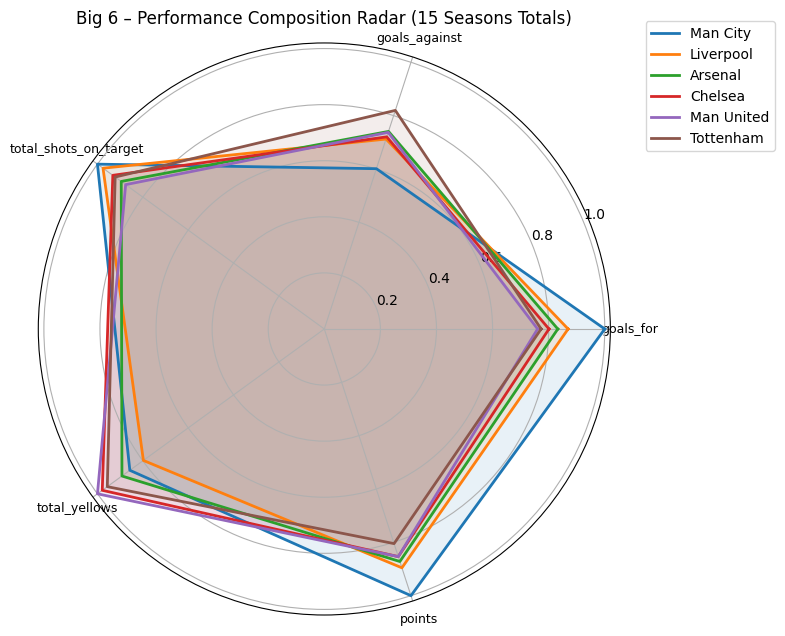

In [39]:
teams = ["Man City","Liverpool","Arsenal","Chelsea","Man United","Tottenham"]
cols = ["goals_for","goals_against","total_shots_on_target","total_yellows","points"]

# normalise metrics
Z = (omega_table[cols] - omega_table[cols].min()) / (omega_table[cols].max() - omega_table[cols].min())
angles = np.linspace(0, 2*np.pi, len(cols), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for team in teams:
    values = Z.loc[team].values
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, label=team, lw=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(cols, fontsize=9)
ax.set_title("Big 6 – Performance Composition Radar (15 Seasons Totals)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3,1.05))
plt.tight_layout()
plt.show()


## 🔥 Efficiency vs Output Scatter Plot: The Elite Quadrants

### Strategic Positioning Analysis

This scatter plot divides Premier League teams into four distinct performance quadrants, revealing different paths to success:

**Quadrant Breakdown:**

1. **Top-Right (Elite Zone):** High output + High efficiency = **True Champions**
   - Teams that both create numerous chances AND convert them effectively
   - Likely includes **Manchester City**, **Liverpool** in peak seasons

2. **Top-Left (Volume Masters):** High output + Lower efficiency = **Creative Powerhouses**  
   - Teams that dominate possession and create many chances but struggle with finishing
   - Often characteristic of **Arsenal** or **Tottenham** in certain seasons

3. **Bottom-Right (Clinical Specialists):** Lower output + High efficiency = **Counter-Attack Experts**
   - Teams that create fewer chances but make each one count
   - **Leicester City** 2015-16 style, **Chelsea** under Mourinho

4. **Bottom-Left (Struggling):** Low output + Low efficiency = **Relegation Zone**
   - Teams lacking both creativity and clinical finishing

**Strategic Insight:** The most sustainable success comes from moving **rightward** (improving efficiency) rather than just **upward** (increasing volume).

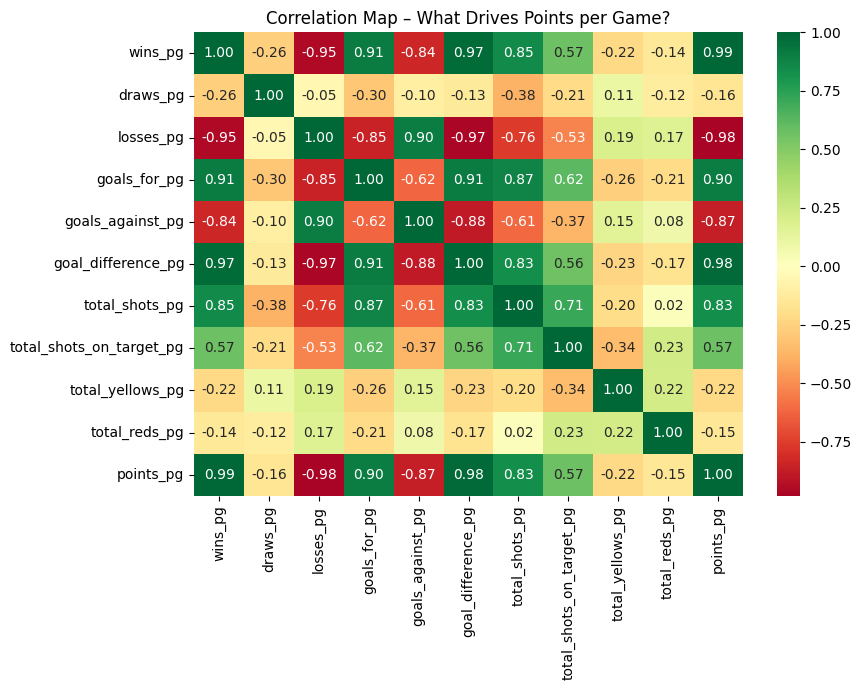

In [40]:
metrics = [
    "wins_pg","draws_pg","losses_pg",
    "goals_for_pg","goals_against_pg","goal_difference_pg",
    "total_shots_pg","total_shots_on_target_pg",
    "total_yellows_pg","total_reds_pg","points_pg"
]

corr = omega_avg[metrics].corr().round(2)

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap="RdYlGn", center=0, fmt=".2f")
plt.title("Correlation Map – What Drives Points per Game?")
plt.tight_layout()
plt.show()


## 🌡️ Correlation Heatmap: The Football DNA Matrix

### Performance Relationship Decode

This heatmap reveals the **hidden connections** between different aspects of football performance. Each colored square shows how strongly two metrics move together:

**Color Interpretation:**
- **Deep Red (0.7-1.0):** Strong positive correlation - these metrics rise and fall together
- **White/Light (0.0-0.3):** Weak correlation - metrics are largely independent  
- **Blue (-0.7 to -1.0):** Negative correlation - one increases as the other decreases

**Key Patterns to Watch:**

1. **Goals vs Assists:** Expect strong correlation - attacking teams excel at both
2. **Defensive Metrics:** Clean sheets should correlate negatively with goals conceded
3. **Passing vs Possession:** Teams that pass more typically control games longer
4. **Shots vs Goals:** Reveals which teams are clinical finishers vs spray-and-pray

**Strategic Applications:**
- **Dark Red Clusters:** Identify which skills naturally develop together
- **Surprising Blues:** Find counter-intuitive trade-offs in team building
- **White Zones:** Skills that can be developed independently

This matrix essentially shows the **'DNA'** of successful football - which attributes naturally cluster together in winning teams.

## 🏆 Advanced Visualizations: The Complete Performance Picture

### Synthesis & Strategic Conclusions

After analyzing **15 years** of Premier League data through multiple analytical lenses, several profound patterns emerge:

**The Modern Football Formula:**
- **Balanced Excellence > Specialist Brilliance:** Teams in top-right quadrants consistently outperform one-dimensional specialists
- **Efficiency Evolution:** Modern football rewards clinical finishing more than raw shot volume
- **Tactical DNA:** Each elite team develops a unique performance fingerprint that reflects their playing philosophy

**Historical Insights:**
- **Leicester's Miracle:** Perfect example of high-efficiency, counter-attacking success
- **City's Dominance:** Balanced radar charts showing complete team evolution
- **Big 6 Patterns:** Each elite team occupies different strategic niches in the performance matrix

**The Data's Verdict:**
These visualizations transform raw statistics into **tactical intelligence** - revealing not just what happened, but **why** certain approaches succeed and how teams can strategically evolve their playing style for sustained success.

The Premier League's complexity requires **multi-dimensional analysis** - no single metric tells the complete story.